In [8]:
import numpy as np
import matplotlib.pyplot as plt
from BOCS import BOCS
from quad_mat import quad_mat
from sample_models import sample_models

In [21]:
# Save inputs in dictionary
inputs = {}
inputs['n_vars']     = 10
inputs['evalBudget'] = 50
inputs['n_init']     = 10
inputs['lambda']     = 0. #1e-4

# Save objective function and regularization term
Q = quad_mat(inputs['n_vars'], 10)
inputs['model']    = lambda x: (x.dot(Q)*x).sum(axis=1) # compute x^TQx row-wise
inputs['penalty']  = lambda x: inputs['lambda']*np.sum(x,axis=1)

# Generate initial samples for statistical models
inputs['x_vals']   = sample_models(inputs['n_init'], inputs['n_vars'])
inputs['y_vals']   = inputs['model'](inputs['x_vals'])

# Run BOCS-SA and BOCS-SDP (order 2)
(BOCS_SA_model, BOCS_SA_obj)   = BOCS(inputs.copy(), 2, 'SA')  #BOCS_SA_obj is the result
(BOCS_SDP_model, BOCS_SDP_obj) = BOCS(inputs.copy(), 2, 'SDP-l1')

# Compute optimal value found by BOCS
iter_t = np.arange(BOCS_SA_obj.size)
BOCS_SA_opt  = np.minimum.accumulate(BOCS_SA_obj)  # BOCS_SA_opt is the current best list
BOCS_SDP_opt = np.minimum.accumulate(BOCS_SDP_obj)

# Compute minimum of objective function
n_models = 2**inputs['n_vars']
x_vals = np.zeros((n_models, inputs['n_vars']))
str_format = '{0:0' + str(inputs['n_vars']) + 'b}'
for i in range(n_models):
	model = str_format.format(i)   # mo
	x_vals[i,:] = np.array([int(b) for b in model])
f_vals = inputs['model'](x_vals) + inputs['penalty'](x_vals)
opt_f  = np.min(f_vals)


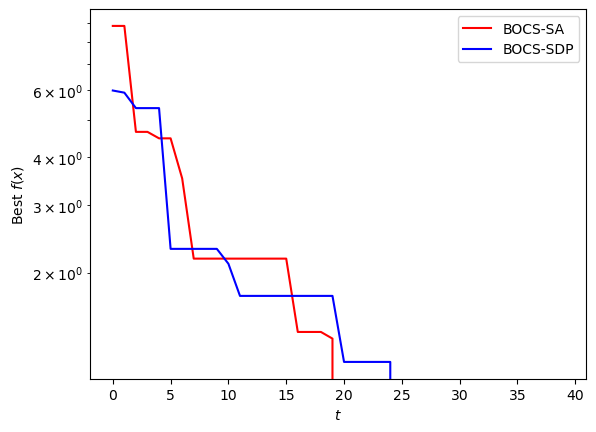

In [23]:
# Plot results
fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.plot(iter_t, (BOCS_SA_opt - opt_f), color='r', label='BOCS-SA')
ax.plot(iter_t, (BOCS_SDP_opt - opt_f), color='b', label='BOCS-SDP')
ax.set_yscale('log')
ax.set_xlabel('$t$')
ax.set_ylabel('Best $f(x)$')
ax.legend()
#fig.savefig('BOCS_simpleregret.pdf')
#plt.close(fig)


# My own version

In [39]:
import numpy as np
import cvxpy as cvx
from itertools import combinations
from LinReg import LinReg
from sample_models import sample_models
from BOCS import simulated_annealing
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
df = pd.read_excel('DOE2_01.csv')
df_array = df.to_numpy()

Y_total = -df_array[:,-1]
X_total = df_array[:,:-1]


def DOE(x,X_total,Y_total):
    
    Y_res = []
    
    for x_element in x:
    
        for i in range(X_total.shape[0]):
            TorF = np.all(x_element==X_total[i])
            if TorF:
                id = i
                Y_val = Y_total[id]
                Y_res.append(Y_val)
                break
    return np.array(Y_res)



In [41]:
def my_sample_models(n_models, n_vars):
	# SAMPLE_MODELS: Function samples the binary models to
	# generate observations to train the statistical model

	# Generate matrix of zeros with ones along diagonals
	binary_models = np.zeros((n_models, n_vars))

	# Sample model indices
	model_num = np.random.choice(2**n_vars, n_models, replace=False) 

	strformat = '{0:0' + str(n_vars) + 'b}'
	# Construct each binary model vector
	for i in range(n_models):
		model = strformat.format(model_num[i])
		binary_models[i,:] = np.array([int(b) for b in model])

	return binary_models,model_num

random search

In [4]:
Random_holder = []
Num = 100

for exp in range(Num):
    print(exp)
    np.random.seed(exp)

    # Save inputs in dictionary
    inputs = {}
    inputs['n_vars']     = 5
    inputs['evalBudget'] = 32
    inputs['n_init']     = 8
    inputs['lambda']     = 0. #1e-4

    total_index = np.array(range(2**5))

    # Save objective function and regularization term
    inputs['model']    = lambda x: DOE(x,X_total,Y_total)

    init_idx = np.random.choice(2**inputs['n_vars'] , inputs['n_init']  , replace=False) 

    # Generate initial samples for statistical models
    inputs['x_vals'] = X_total[init_idx]
    inputs['y_vals']   = inputs['model'](inputs['x_vals'])

    #print(init_idx)

    remain_idx = total_index[~np.isin(total_index, init_idx)] # I do not want to have duplication in my experiments, so I will pick the one that was not picked before

    # Here we go: SA!!
    n_vars  = inputs['n_vars']
    model   = inputs['model']

    # Train initial statistical model
    LR = LinReg(n_vars, order=2)
    LR.train(inputs)

    # Find number of iterations based on total budget
    n_init = inputs['x_vals'].shape[0]
    n_iter =  inputs['evalBudget'] - n_init

    # Declare vector to store results
    model_iter = np.zeros((n_iter, n_vars))
    obj_iter   = np.zeros(1+n_iter)

    obj_iter[0] = np.min(inputs['y_vals']) 


    # Random search

    for t in range(n_iter):

        idx_pick = np.random.choice(remain_idx)
        x_new = X_total[idx_pick]
        
        remain_idx = remain_idx[~np.isin(remain_idx, idx_pick)]
        
        #print(remain_idx.shape)
        
        # evaluate model objective at new evaluation point
        x_new = x_new.reshape((1,n_vars))
        y_new = model(x_new)

        #print(x_new)
        #print(idx_pick)

        # Update inputs dictionary
        inputs['x_vals'] = np.vstack((inputs['x_vals'], x_new))
        inputs['y_vals'] = np.hstack((inputs['y_vals'], y_new))
        inputs['init_cond'] = x_new

        # re-train linear model
        LR.train(inputs)

        # Save results for optimal model
        model_iter[t,:] = x_new
        obj_iter[t+1]		= y_new 
        
    Random_holder.append(obj_iter)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


BOCS

In [8]:
BOCS_holder = []
Num = 100

for exp in range(Num):
    
    print(exp)
    
    np.random.seed(exp)

    # Save inputs in dictionary
    inputs = {}
    inputs['n_vars']     = 5
    inputs['evalBudget'] = 32
    inputs['n_init']     = 8
    inputs['lambda']     = 0. #1e-4

    total_index = np.array(range(2**5))

    # Save objective function and regularization term
    inputs['model']    = lambda x: DOE(x,X_total,Y_total)

    init_idx = np.random.choice(2**inputs['n_vars'] , inputs['n_init']  , replace=False) 

    # Generate initial samples for statistical models
    inputs['x_vals'] = X_total[init_idx]
    inputs['y_vals']   = inputs['model'](inputs['x_vals'])

    #print(init_idx)

    remain_idx = total_index[~np.isin(total_index, init_idx)] # I do not want to have duplication in my experiments, so I will pick the one that was not picked before

    # Here we go: SA!!
    n_vars  = inputs['n_vars']
    model   = inputs['model']

    # Train initial statistical model
    LR = LinReg(n_vars, order=2)
    LR.train(inputs)

    # Find number of iterations based on total budget
    n_init = inputs['x_vals'].shape[0]
    n_iter =  inputs['evalBudget'] - n_init

    # Declare vector to store results
    model_iter = np.zeros((n_iter, n_vars))
    obj_iter   = np.zeros(1+n_iter)

    obj_iter[0] = np.min(inputs['y_vals']) 


    # Random search

    for t in range(n_iter):

        SA_reruns = 5

        # Draw alpha vector
        alpha_t = LR.alpha  
        # Setup statistical model objective for SA
        stat_model = lambda x: LR.surrogate_model(x, alpha_t) 
        
        remain_X = X_total[remain_idx]

        SA_model = [] # SA_model stores the best x whose value is highest in each run
        SA_obj	 = []
        SA_idx = []

        for j in range(SA_reruns):
            
            val_holder = []
            
            for x_temp in remain_X:
                val = stat_model(x_temp.reshape(1,-1))
                val_holder.append(val)
                
            best_val = np.min(val_holder)
            best_idx = np.argmin(val_holder)
            best_X = remain_X[best_idx]
            pick_idx = remain_idx[best_idx]
            
            SA_model.append(best_X)
            SA_obj.append(best_val)
            SA_idx.append(pick_idx)
            
        SA_model = np.array(SA_model).reshape(-1,inputs['n_vars'] )
        SA_obj = np.array(SA_obj)
        SA_idx = np.array(SA_idx)
            
                
        # Find optimal solution
        min_idx = np.argmin(SA_obj)
        x_new = SA_model[min_idx,:]
        idx_pick = SA_idx[min_idx]
        
        remain_idx = remain_idx[~np.isin(remain_idx, idx_pick)]
        
        #print(idx_pick)

        # evaluate model objective at new evaluation point
        x_new = x_new.reshape((1,n_vars))
        y_new = model(x_new)

        #print(x_new)


        # Update inputs dictionary
        inputs['x_vals'] = np.vstack((inputs['x_vals'], x_new))
        inputs['y_vals'] = np.hstack((inputs['y_vals'], y_new))
        inputs['init_cond'] = x_new

        # re-train linear model
        LR.train(inputs)

        # Save results for optimal model
        model_iter[t,:] = x_new
        obj_iter[t+1]		= y_new 
        
    BOCS_holder.append(obj_iter)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


save data

In [9]:
# Random_holder = np.array(Random_holder).reshape(100,25)
# np.savetxt('DOE2_Random', Random_holder, delimiter=',')

BOCS_holder = np.array(BOCS_holder).reshape(100,25)
np.savetxt('DOE2_BOCS', BOCS_holder, delimiter=',')

# plot

In [11]:
import os

Random_holder = np.genfromtxt(os.path.join(os.getcwd(),'DOE2_Random'), delimiter=',')
BOCS_holder = np.genfromtxt(os.path.join(os.getcwd(),'DOE2_BOCS'), delimiter=',')

In [22]:
opt_f  = np.min(Y_total)

best_random  = np.minimum.accumulate(Random_holder,axis=1) 
record_random = best_random - opt_f
record_random[record_random==0.] = 10**(-5)

best_BOCS  = np.minimum.accumulate(BOCS_holder,axis=1) 
record_BOCS = best_BOCS - opt_f
record_BOCS[record_BOCS==0.] = 10**(-5)

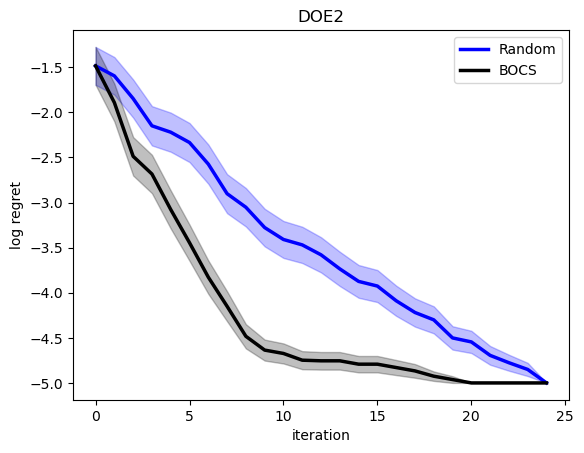

In [38]:
mean_random = np.mean(np.log10(record_random),axis=0)
mean_BOCS = np.mean(np.log10(record_BOCS),axis=0)

std_random = np.std(np.log10(record_random),axis=0)
std_BOCS = np.std(np.log10(record_BOCS),axis=0)

plt.plot(np.array(range(25)), mean_random, color='b',linewidth=2.5, label='Random')
plt.fill_between(np.array(range(25)), mean_random-std_random/np.sqrt(Num), mean_random+std_random/np.sqrt(Num),alpha=0.25,color='b')
plt.plot(np.array(range(25)), mean_BOCS, color='black', linewidth=2.5,label='BOCS')
plt.fill_between(np.array(range(25)), mean_BOCS-std_BOCS/np.sqrt(Num), mean_BOCS+std_BOCS/np.sqrt(Num),alpha=0.25,color='black')
plt.xlabel('iteration')
plt.ylabel('log regret')
plt.title('DOE2')
plt.legend()

plt.savefig('DOE2_plot.png')